# CrewAI Observability with Langfuse

[Langfuse](https://langfuse.com/) is an open-source observability and analytics platform designed specifically for LLM applications. Langfuse helps you track, monitor, and analyze your LLM application's performance, costs, and behavior.

With Langfuse, you can:

- Track and analyze LLM interactions and their associated costs
- Monitor model performance and latency
- Debug production issues with detailed tracing
- Evaluate output quality and model behavior
- Collect user feedback and ground truth data and more.

## Setup

We'll walk through creating a Langfuse account, setting up a project, generating API credentials, and configuring custom model definitions. This will prepare us to start tracing our LLM applications.

**Important**: for the sake of this workshop, we will not be creating a custom server running LangFuse, and will instead use the [SaaS version](https://cloud.langfuse.com/) of the product. If you want, you can learn how to host your own LangFuse server on [Langfuse doc](https://langfuse.com/self-hosting), or using this [GitHub repository](https://github.com/aws-samples/deploy-langfuse-on-ecs-with-fargate/).

1. Start by **creating your account on [LangFuse Cloud](https://cloud.langfuse.com/)**
1. Create a **New Organization** and enter an organization name, for example `AnyCompany`. Skip the Invite Members step.
1. Enter a **name** for the new project and click **Create**.
1. Note down the **Secret Key**, **Public Key** and **Host** on your computer. Note you can also find the credentials in the *Settings -> API Keys* page.
1. We will be using the `langfuse` SDK to achieve our goals of obtaining traces and logs for our agents.

## Tracing

In [ ]:
%pip install -r crewai-requirements.txt --upgrade --quiet
%pip install langfuse openlit duckduckgo_search --upgrade --quiet

Set your Langfuse API keys and configure OpenTelemetry export settings to send traces to Langfuse. Please refer to the [Langfuse OpenTelemetry Docs](https://langfuse.com/docs/opentelemetry/get-started) for more information on the Langfuse OpenTelemetry endpoint `/api/public/otel` and authentication.

In [13]:
import os
from dotenv import load_dotenv

# Load .env vars for Langfuse and Serper
load_dotenv()
if os.getenv("LANGFUSE_PUBLIC_KEY") is None:
    os.environ["LANGFUSE_PUBLIC_KEY"] = input("Enter your Langfuse public key: ")
if os.getenv("LANGFUSE_SECRET_KEY") is None:
    os.environ["LANGFUSE_SECRET_KEY"] = input("Enter your Langfuse secret key: ")
if os.environ["SERPER_API_KEY"] is None:
    os.environ["SERPER_API_KEY"] = input("Enter your Serper API key: ", None)
    if os.environ["SERPER_API_KEY"] is None:
        from crewai.tools import tool
        from duckduckgo_search import DDGS

        @tool('DuckDuckGoSearch')
        def search_tool(search_query: str):
            """Search the web for information on a given topic"""
            return DDGS().text(search_query, max_results=5)

In [14]:
import base64

LANGFUSE_AUTH=base64.b64encode(f"{os.environ['LANGFUSE_PUBLIC_KEY']}:{os.environ['LANGFUSE_SECRET_KEY']}".encode()).decode()

os.environ["OTEL_EXPORTER_OTLP_ENDPOINT"] = "https://cloud.langfuse.com/api/public/otel" # EU data region
# os.environ["OTEL_EXPORTER_OTLP_ENDPOINT"] = "https://us.cloud.langfuse.com/api/public/otel" # US data region
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"Authorization=Basic {LANGFUSE_AUTH}"

Initialize the OpenLit OpenTelemetry instrumentation SDK to start capturing OpenTelemetry traces.

In [15]:
import openlit

openlit.init()

2025-04-10 16:04:29,542 - 8221214784 - __init__.py-__init__:349 - ERROR: OpenLIT metrics setup failed. Metrics will not be available: 'NoneType' object has no attribute 'create_histogram'


Start tracing!

In [16]:
from crewai import LLM

model = LLM(
    # model="sagemaker/INSERT ENDPOINT NAME",
    model="bedrock/us.amazon.nova-pro-v1:0",
    temperature=0.7, max_tokens=4*1024,
)

In [17]:
from crewai import Agent, Task, Crew
from crewai_tools import SerperDevTool

search_tool = SerperDevTool(n_results=5)

writer = Agent(
        role="Writer",
        goal="You make math engaging and understandable for young children through poetry",
        backstory="You're an expert in writing haikus but you know nothing of math.",
        tools=[search_tool],
        llm=model
    )

task = Task(description=("What is {topic}?"),
            expected_output=("Compose a short poem that includes the answer."),
            agent=writer)

crew = Crew(
  agents=[writer],
  tasks=[task],
  share_crew=False
)

result = crew.kickoff({"topic": "Amazon Bedrock"})
print(result)

In cloud's embrace,
AI whispers secrets, 
Bedrock's gentle grace.


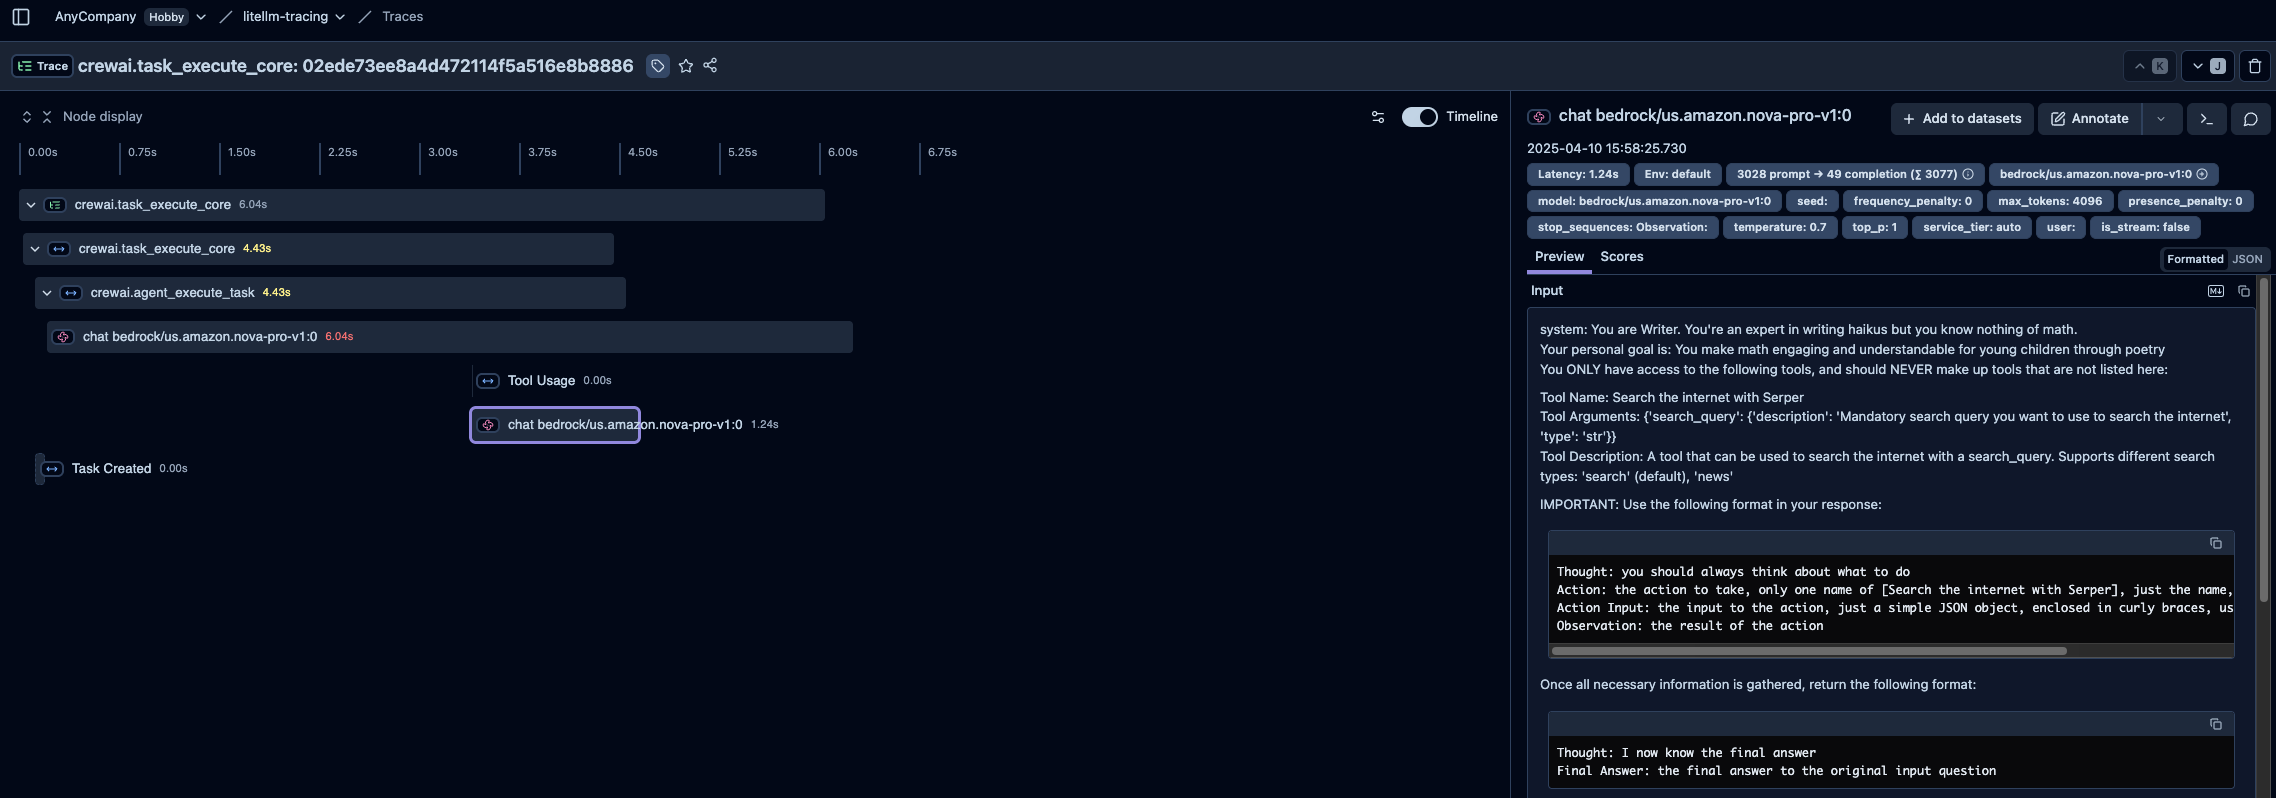